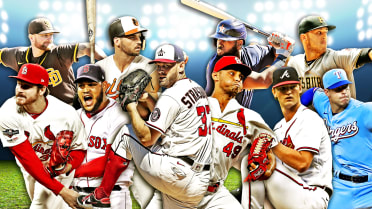
# Introduction:
Major League Baseball (MLB) is an American professional baseball organization and the oldest of the major professional sports leagues in the United States and Canada. 
The sport has a long history of being numbers-driven. Nearly every day from at least April through October, baseball fans watch, read, and search for information about players.MLB continues its leadership using technology to engage fans and provide new fans innovative ways to experience America’s Favorite Pastime.

# Problem Statement:
Predict how fans engage with MLB players’ with help of digital content on a daily basis for a future date range. We’ll have access to player performance data, social media data, and team factors like market size.So forecast four different measures of engagement (target1-target4) for a subset of MLB players who are active in the 2021 season.

# Data:
The data contains a set of static files that do not change with time
- 1.players.csv
- 2.teams.csv
- 3.seasons.csv
- 4.awards.csv
- daily data (train.csv) which is grouped by day.

When predicting on a given date, we are forecasting the target variables for the next day (i.e. for date d, you're predicting the engagement for day d+1).


In [ ]:
import re
import os
import numpy as np
import pandas as pd
import random as rn
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()
from plotly.offline import init_notebook_mode, iplot 
import plotly.graph_objs as go
import plotly.offline as py
import pycountry
py.init_notebook_mode(connected=True)
import folium 
from folium import plugins
from pathlib import Path


import gc
import sys
import warnings
from pathlib import Path

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import (CalendarFourier,
                                           CalendarSeasonality,
                                           CalendarTimeTrend,
                                           DeterministicProcess)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

warnings.simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

In [ ]:
train=pd.read_csv("../input/mlb-player-digital-engagement-forecasting/train.csv")
test=pd.read_csv('../input/mlb-player-digital-engagement-forecasting/example_test.csv')
sub=pd.read_csv("../input/mlb-player-digital-engagement-forecasting/example_sample_submission.csv")
def get_dataset_information(df):
    '''
    Take a first view of dataset
    '''
    print("Number of Columns in dataset:",df.shape[1])
    print("Number of Rows in dataset:",df.shape[0])
    print("Name of Columns in dataset:",df.columns)
   # print(df.describe())
    print(df.info())
    return df.head(5)

def calculate_missing_percentage(df):
    ''' calculate missing percentage in data and stored as missing_stat
    Input: Give dataset, in which you like to check missing values
    '''
    missing_stat=df.isnull().sum()/len(df)*100
    #convert missing_stat into dataframe
    prod_count = pd.DataFrame(missing_stat.sort_index())
    plt.figure()
    #plot in barplot
    sns.barplot(x=missing_stat.index, y=missing_stat.values, alpha=0.8)
    plt.title('Percent Missing')
    plt.ylabel('Missing', fontsize=12)
    plt.xlabel('Features', fontsize=12)
    plt.xticks(rotation=90)
    plt.show()
    
def draw_num_plot(df,column,col):
    '''Draw KDE plot for given dataset and particular column
    Inputs: Pass dataframe and particular column and also pass color for making interactive map
    '''
    plt.figure(figsize=(15,8))
    mean=df[column].mean()
    median=df[column].median()
    sns.axes_style("dark")
    ax=sns.kdeplot(data=df, x=column,fill=True,color=col)
    ax.axvline(mean, color='crimson', linestyle='dotted')
    ax.axvline(median, color='g', linestyle='-')
    plt.legend({'Mean':mean,'Median':median})
    plt.show()
    

def q_q_plot(df,column):
    '''Check data column follow normal distribution or not by using Q-Q plot
    '''
    data = df[column]
    # q-q plot
    plt.figure(figsize=(15,8))
    qqplot(data, line='s')
    
    plt.show()

def draw_correlation_matrix(df):
    plt.figure(figsize=(18,6))
    #find correlation between data columns
    corrMatrix = df.corr()
    #plot by using heatmap
    sns.heatmap(corrMatrix,annot = True, vmin=-1, vmax=1, center= 0)
    plt.show()
    

# Train File:
This contains data on MLB players active at some point since 2018. Predictions are only scored for those players active in 2021,but previous seasons’ players are included here to provide more data for exploration and modeling purposes.


In [ ]:
#change the date format
train['date'] = pd.to_datetime(train['date'], format = "%Y%m%d")
get_dataset_information(train)

- "nextDayPlayerEngagement": Nested JSON containing all modeling targets from the following day.

In [ ]:
get_dataset_information(test)

In [ ]:
get_dataset_information(sub)

In [ ]:
award=pd.read_csv("../input/mlb-player-digital-engagement-forecasting/awards.csv")
get_dataset_information(award)

# What are The most common awardName?

In [ ]:
from collections import Counter
def find_common_words_and_count(dataframe,col_name):
    dataframe['temp_list'] = dataframe[col_name].head(30)
    top = Counter(dataframe[col_name])
    temp = pd.DataFrame(top.most_common(50))
    temp.columns = ['Common_words','count']
    temp.style.background_gradient(cmap='Green')
    return temp
#find_common_words_and_count(award,'awardName')
import plotly.express as px
fig = px.bar(find_common_words_and_count(award,'awardName'), x="count", y="Common_words", title='Top 30 AwardNames', orientation='h', 
             width=1000, height=700,color='Common_words')
fig.show()

fig = px.treemap(find_common_words_and_count(award,'awardName'), path=['Common_words'], values='count',title='Top 30 AwardNames')
fig.show()

In [ ]:
from plotly.offline import init_notebook_mode, iplot 
trace1 = go.Bar(
                    y=award['playerName'].value_counts().index[0:20],
                    x =award['playerName'].value_counts(sort=True).values[0:20],
                    orientation='h',
                    marker = dict(color='plum',
                                 line=dict(color='skyblue',width=1)),
                    text = train.index)
data = [trace1]
layout = go.Layout(barmode = "group",title="playerName",width=800, height=500, 
                       xaxis= dict(title="playerName"),
                       yaxis=dict(autorange="reversed"),
                       showlegend=False)
fig = go.Figure(data = data, layout = layout)
iplot(fig)

In [ ]:
labels = award['playerName'].value_counts().index[0:20]
values =award['playerName'].value_counts().values[0:20]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.show()

In [ ]:
players=pd.read_csv("../input/mlb-player-digital-engagement-forecasting/players.csv")
get_dataset_information(players)

In [ ]:
labels = players['birthCountry'].value_counts().index[0:20]
values =players['birthCountry'].value_counts().values[0:20]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_layout(
    title_text="Top 20 Countries",
   )
fig.show()

- 1. No doubt MLB is an American professional baseball organization so the Major contribution also from USA but some players are also coming from other parts also.

In [ ]:
team=pd.read_csv("../input/mlb-player-digital-engagement-forecasting/teams.csv")
get_dataset_information(team)

# Work in Progress